### Install all the necessary libraries

In [8]:
%pip install 'qiskit[visualization]'
%pip install qiskit
%pip install qiskit_algorithms
%pip install matplotlib
%pip install nbformat


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Prepare hydrogen 4-qubit Hamiltonian

In [9]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization.array import array_to_latex

c0 = -0.80718
c1 = 0.17374
c2 = -0.23047
c3 = 0.12149
c4 = 0.16940
c5 = -0.04509
c6 = 0.04509
c7 = 0.16658
c8 = 0.17511

hamiltonian = SparsePauliOp.from_list([
    ("IIII", c0),
    ("ZIII", c1),
    ("ZZII", c2),
    ("IIZI", c1),
    ("IZZZ", c2),
    ("IZII", c3),
    ("ZIZI", c4),
    ("XZXI", c5),
    ("XIXZ", c6),
    ("XIXI", c6),
    ("XZXZ", c5),
    ("ZZZZ", c7),
    ("ZZZI", c7),
    ("ZIZZ", c8),
    ("IZIZ", c3),
])

# 2^4 --> 16 by 16 matrix
# array_to_latex(hamiltonian)

### Prepare ansatzes

In [10]:
%run ansatz.ipynb
%store -r linear_ansatz
%store -r circular_ansatz
%store -r full_ansatz
%store -r pairwise_ansatz

ansatzes = [linear_ansatz, circular_ansatz, full_ansatz, pairwise_ansatz]
ansatzes_name = ["linear", "circular", "full", "pairwise"]

Stored 'linear_ansatz' (TwoLocal)
Stored 'full_ansatz' (TwoLocal)
Stored 'circular_ansatz' (TwoLocal)
Stored 'pairwise_ansatz' (TwoLocal)


### VQE - test multiple optimizers

In [11]:
from qiskit.primitives import Estimator
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=600), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
estimator = Estimator()
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, linear_ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete");

Optimization complete


##### Print the results

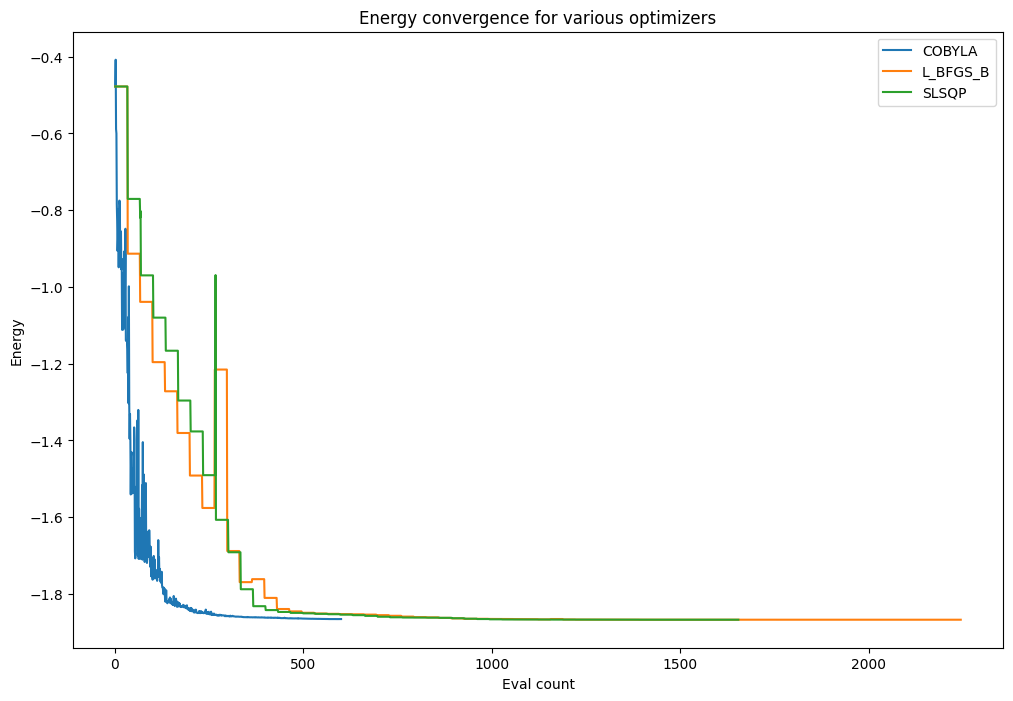

In [12]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

### VQE - test multiple ansatzes

In [13]:
from qiskit.primitives import Estimator
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# we will iterate over these different optimizers
converge_counts = np.empty([len(ansatzes)], dtype=object)
converge_vals = np.empty([len(ansatzes)], dtype=object)

for i, ansatz in enumerate(ansatzes):
    print(r"Ansatz: ", ansatzes_name[i])
    algorithm_globals.random_seed = 50

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(Estimator(), ansatz, L_BFGS_B(maxiter=60), callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete");

Ansatz:  linear
Ansatz:  circular
Ansatz:  full
Ansatz:  pairwise
Optimization complete


##### Print the results

In [ ]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(ansatzes):
    pylab.plot(converge_counts[i], converge_vals[i], label=ansatzes_name[i])
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");